In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

# Load data

In [2]:
data = pd.read_excel('whole_dataset.xlsx')
cols5 = ['qtype','Al', 'Ti', 'Li', 'Ge','Sr']
for ele in cols5[1:]:
    data[ele] = pd.to_numeric(data[ele], errors='coerce')
df5 = data.loc[: , cols5].dropna()
print(len(df5))    # number of samples
df5.qtype.value_counts() # number of samples in each class

1690


orogenic      339
greisen       325
porphyry      272
granite       237
skarn         203
carlin        127
IRG            96
pegmatite      65
epithermal     26
Name: qtype, dtype: int64

In [3]:
X = df5.drop('qtype', axis=1).astype(float)
y = df5['qtype']

In [4]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# samples in testset for each class
y_test.value_counts()

greisen       70
orogenic      64
skarn         49
porphyry      48
granite       45
carlin        25
IRG           17
pegmatite     13
epithermal     7
Name: qtype, dtype: int64

# Make Pipeline

In [5]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(), SVC())
pipe_clf

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

# Parameter estimation using grid search with cross-validation


In [6]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
C_range = np.logspace(-2, 8, 16 , base=2)
gamma_range = np.logspace(-5, 3, 16, base=2)

param_grid = {'svc__kernel': ['rbf'], 'svc__gamma': gamma_range,
                     'svc__C': C_range}                   
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2)


In [8]:
grid = GridSearchCV(pipe_clf, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'svc__C': 4.0, 'svc__gamma': 0.6015125180410583, 'svc__kernel': 'rbf'} with a score of 0.87


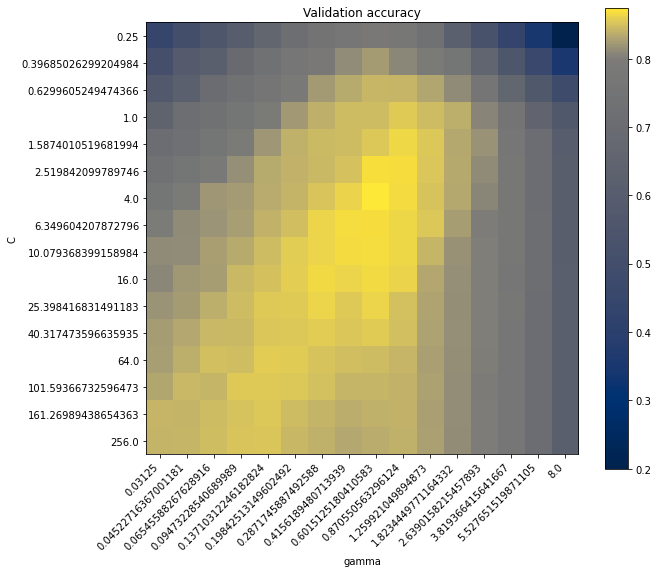

In [9]:
# Visualization

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.cividis,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.8))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45, ha='right')
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

# Model retrain


In [10]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(),
                         SVC(C=grid.best_params_['svc__C'], kernel='rbf',
                             gamma=grid.best_params_['svc__gamma'], cache_size=1000))

In [11]:
pipe_clf.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=4.0, cache_size=1000, gamma=0.6015125180410583))])

In [12]:
y_pred = pipe_clf.predict(X_test)
pred_train = pipe_clf.predict(X_train)

In [13]:
# train set report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         IRG       0.85      0.94      0.89        79
      carlin       0.98      1.00      0.99       102
  epithermal       1.00      0.95      0.97        19
     granite       0.92      0.96      0.94       192
     greisen       0.91      0.93      0.92       255
    orogenic       0.94      0.93      0.93       275
   pegmatite       0.94      0.87      0.90        52
    porphyry       0.93      0.94      0.94       224
       skarn       0.94      0.84      0.89       154

    accuracy                           0.93      1352
   macro avg       0.94      0.93      0.93      1352
weighted avg       0.93      0.93      0.93      1352



In [14]:
# final evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         IRG       0.88      0.88      0.88        17
      carlin       1.00      0.88      0.94        25
  epithermal       1.00      0.71      0.83         7
     granite       0.86      0.96      0.91        45
     greisen       0.82      0.84      0.83        70
    orogenic       0.83      0.89      0.86        64
   pegmatite       0.77      0.77      0.77        13
    porphyry       0.84      0.90      0.87        48
       skarn       0.87      0.69      0.77        49

    accuracy                           0.85       338
   macro avg       0.87      0.84      0.85       338
weighted avg       0.86      0.85      0.85       338

[[15  0  0  1  0  1  0  0  0]
 [ 0 22  0  0  0  1  0  0  2]
 [ 0  0  5  0  0  1  0  1  0]
 [ 0  0  0 43  1  0  1  0  0]
 [ 0  0  0  6 59  1  0  4  0]
 [ 0  0  0  0  3 57  0  1  3]
 [ 1  0  0  0  2  0 10  0  0]
 [ 0  0  0  0  4  1  0 43  0]
 [ 1  0  0  0  3  7  2  2 34]]


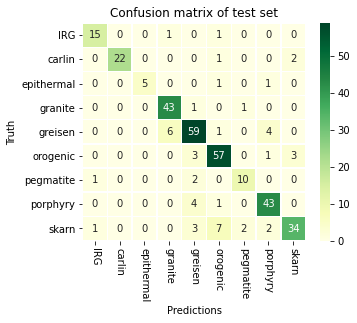

In [15]:
# heatmap the confusion matrix of test data
label_order = ['IRG', 'carlin','epithermal', 'granite', 'greisen', 'orogenic', 'pegmatite', 'porphyry', 'skarn']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  columns=label_order, index=label_order)

f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='YlGn')
ax.set(title='Confusion matrix of test set', xlabel='Predictions', ylabel='Truth')
plt.xticks(rotation=270)
# f.savefig('./figures/confusion_matrix.png', dpi=150)

# Model persistence

In [16]:
from joblib import dump, load
dump(pipe_clf, 'quartz_clf.joblib') 

['quartz_clf.joblib']